Capital Production Game
Author : Jung Hyun Kim (Department of Economics, University of Tokyo)

From Miranda and Fackler, Applied Computational Economics and Finance, 2002, Section 8.5.1 and 9.8.1

s: state of system

x:  action 

f : reward

V: value function

capital at next period is (1-ξ )k_i+x_i

state transition function: 
g(k1,k2,x1,x2,q1,q2)= ((1−ξ)k1 +x1,(1−ξ)k2 +x2) 

reward function : 
fi(k1, k2, x1, x2, q1, q2) = P (q1, q2)qi − ci(qi, ki) − hi(xi) 

short-run profit, exclusive of investment costs : π_p(c1, c2) 

In [1]:
using BasisMatrices
using QuantEcon
using PyPlot
using Distributions

In [2]:
# set environment
n = 8
smin = 0.7
smax = 1.3
maxit = 10000
tol = 0.0000001

# make collocation matrix
sgrid0 = linspace(smin, smax, n)
basis = Basis(SplineParams(sgrid0, 0, 3), SplineParams(sgrid0, 0, 3))
S, (coordx, coordy) = nodes(basis)
Φ = BasisMatrix(basis, Expanded(), S, 0)

BasisMatrix{BasisMatrices.Expanded} of order [0 0]

In [3]:
mutable struct CPG
    alpha::Array{Float64,1}
    beta::Array{Float64,1}
    gamma::Array{Float64,1}
    psi::Float64
    delta::Float64
end


function cost( model::CPG, s::Array{Float64, 2})
    box=zeros(size(s)[1], 2)
    box[:,1]= model.beta[1]+( model.beta[2] ./ s[:,1])
    box[:,2]= model.beta[1]+( model.beta[2] ./ s[:,2])
    return box
end

cost (generic function with 1 method)

In [4]:
function prof( model::CPG, cost::Array{Float64, 2})
    return (model.alpha[1]-2*cost[:,1]+cost[:,2]).^2/(9*model.alpha[2])
end

prof (generic function with 1 method)

In [5]:
#states s, actions x, and shocks e
function reward( model::CPG, prof::Array{Float64, 1},x::Array{Float64, 2}, p::Int64)     
    return prof-(model.gamma[1]*x[:,p]+0.5*model.gamma[2]*x[:,p].^2)
end

reward (generic function with 1 method)

In [6]:
function capital( model::CPG, x::Array{Float64, 2}, s::Array{Float64, 2})     
    return (1-psi)*s + x
end

capital (generic function with 1 method)

In [7]:
# derivatives of  payoff, transition functions
# reward function

function rewardx( model::CPG, x::Array{Float64, 2}, s::Array{Float64, 2}, p::Int) 
    n = size(s)[1]
    return -(model.gamma[1]+model.gamma[2]*x[:,p]);
end

rewardx (generic function with 1 method)

In [8]:
function rewardxx( model::CPG, x::Array{Float64, 2}, s::Array{Float64, 2},p::Int) 
    n = size(s)[1]
    fxx= zeros(n,2,2)
    fxx[:,p,p] = zeros(n,1)-gamma[2];
    return fxx
    end

rewardxx (generic function with 1 method)

In [9]:
# transition function
function capitalx( model::CPG, x::Array{Float64, 2}, s::Array{Float64, 2}) 
    n = size(s)[1]
    gx = zeros(n,2,2);
    gx[:,1,1] = ones(n,1);
    gx[:,2,2] = ones(n,1);
    return gx
end

capitalx (generic function with 1 method)

In [10]:
function capitalxx( model::CPG, x::Array{Float64, 2}, s::Array{Float64, 2}) 
    n = size(s)[1]
    gxx = zeros(n,2,2,2)
    return gxx
end

capitalxx (generic function with 1 method)

In [11]:
# collocation function
#The collocation method calls for the analyst to select n basis functions φj and n collocation nodes (k1i,k2i), and form the value function approximants Vp(k1,k2) ≈  nj=1 cpjφj(k1,k2) whose coefficients cpj solve the collocation equation

function vmax(model::CPG, colnodes::Array{Float64, 2}, b, action::Array{Float64, 2}, coef::Array{Float64, 2})
    xnew = action
    v = zeros((size(colnodes)[1], 2))
    c = cost(model, colnodes)
    pr = prof(model, c)
    for p in 1:2
        xl, xu = 0.0, Inf
        order1 = [0 0]
        order1[1, p] = 1
        order2 = [0 0]
        order2[1, p] = 2
        for it in 1:maxit
            
            util, util_der1, util_der2 = 
            reward(model, pr, action, p), rewardx(model, action, colnodes,p), rewardxx(model, action, colnodes,p)[:,p,p] 
            Ev, Evx, Evxx = 0.0, 0.0, 0.0
           
            
            transition, transition_der1, transition_der2 = 
            capital(model, action, colnodes), capitalx(model, action, colnodes)[:,p,p], capitalxx(model, action, colnodes)[:,p,p,p]
            
           
            
            vn = funeval(coef[:, p], b, transition)
            vnder1 =  funeval(coef[:, p], b, transition, order1)
            vnder2 = funeval(coef[:, p], b, transition, order2)
            Ev =   vn
            Evx =  vnder1.* transition_der1
            Evxx =  vnder1.*transition_der2 + vnder2 .* (transition_der1.^2)
            
            
            v[:, p] = util + model.delta*Ev
            delx = -(util_der1 + model.delta * Evx) ./ (util_der2 .+ model.delta*Evxx)
            
            
            delx = min.(max.(delx, xl-xnew),xu-action)  
             
            action[:, p] = action[:, p] + delx[:, p]
            
            
            if norm(delx) < tol
                break
            end
        end
        xnew = action
    end
    return v, xnew
end

vmax (generic function with 1 method)

In [12]:
psi = 0.1;
delta = 0.9;
alpha = [8.0 , 4.0];
beta  = [1.8 ,0.2];
gamma = [0.4, 3.0];
model=CPG(alpha, beta, gamma, psi, delta)

CPG([8.0, 4.0], [1.8, 0.2], [0.4, 3.0], 0.1, 0.9)

In [13]:
#set initials
srand(77)
initial = zeros((size(Φ.vals[1])[1]), 2)
x = zeros((size(Φ.vals[1])[1]), 2)+1
v = zeros((size(Φ.vals[1])[1]), 2)
model = CPG([8.0,4.0], [1.8, 0.2],[0.4,3.0], 0.1, 0.9)

# iteration for coefficients
c = initial
c_error = c
count = 0
for it in 1:100
    cold = c
    vnew, x = vmax(model, S, basis, x, c, )
    c = Φ.vals[1] \ vnew
    v = vnew
    c_error = cold - c
    count += 1
    if maximum(abs, cold - c) < tol
        break
    end
end

In [14]:
vmax(model,S,basis,x,initial)

([0.971633 0.971633; 0.97901 0.97901; … ; 1.01312 1.01312; 1.01544 1.01544], [0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0])

In [15]:
xgrid = zeros((n+2, n+2))
ygrid = zeros((n+2, n+2))
for i in 1:n+2
    xgrid[i, :] = coordx
end
for i in 1:n+2
    ygrid[:, i] = coordy
end
z = reshape(x[:, 1], n+2, n+2);

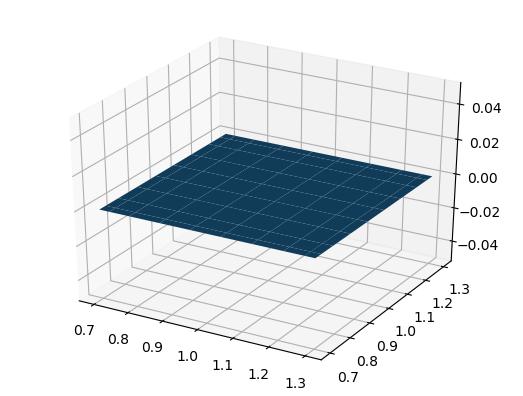

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x10c038790>

In [16]:
# policy function for player 1
surf(xgrid, ygrid, z)

In [17]:
# use vmax on new grid
nn = 30
gri = linspace(smin, smax, nn)
new_grid = gridmake(gri, gri)
cx = Φ.vals[1] \ x
xnew = funeval(cx,basis,new_grid)
v_true = vmax(model,new_grid,basis,xnew[:,:,1],c)[1][:, 1];

In [18]:
# predicted value function
predict_value = funeval(c, basis, new_grid)[:, 1];

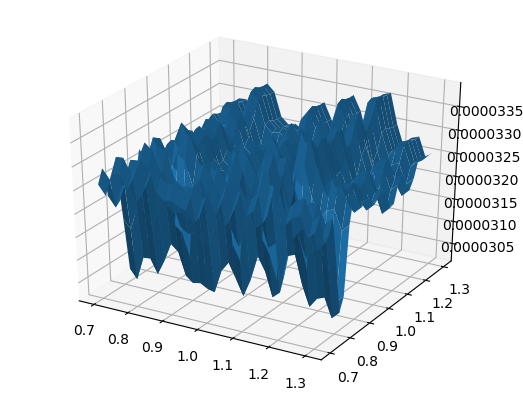

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x11f29ead0>

In [19]:
resid = reshape(v_true - predict_value, nn, nn)
xgrid = zeros((nn, nn))
ygrid = zeros((nn, nn))
for i in 1:nn
    xgrid[i, :] = Array(gri)'
end
for i in 1:nn
    ygrid[:, i] = Array(gri)
end

surf(xgrid, ygrid, resid)

In [20]:
# initial_value :: 1st value is the initial wealth level of player1, 2nd one is for the other player
# policy :: policy function defined over the wealth distribution space
# periods :: simulation period
# p :: the player whose result we want to get

function simulate(model::CPG,
    initial_value::Array{Float64, 1},
    b,
    coef_x,#::Array{Float64, 2},
    periods::Int64,
    p::Int64)
    
    box = ones((1, 2))
    capital_p = zeros(periods+1)
    investment_p = zeros(periods)
    
    capital_transition = zeros((periods+1, 2))
    invest_transition = zeros((periods, 2))
    capital_transition[1,:] = initial_value
    for j in 1:1
        for i in 2:periods+1
            invest = funeval(coef_x, b, [capital_transition[i-1, 1], capital_transition[i-1, 2]])
            box[1, :] = invest
            invest_transition[i-1, :] = box
            
            capital_transition[i, :] = capital(model, x, s)
        end
        capital_p[:, j] = capital_transition[:, p]
        investment_p[:, j] = invest_transition[:, p]
    end

    return mean(capital_p, 2), mean(investment_p, 2)
end

simulate (generic function with 1 method)

In [22]:
# basis coefficient for policy function
c_x =Φ.vals[1] \ x
s= zeros((periods+1)
initial = [0.95, 0.95]
periods = 30

caiptal_result, invest_result = simulate(model, initial, basis, c_x, periods, 1)

LoadError: [91msyntax: missing comma or ) in argument list[39m

In [23]:
plot(capital_result)

LoadError: [91mUndefVarError: capital_result not defined[39m

In [25]:
plot(invest_result)

LoadError: [91mUndefVarError: invest_result not defined[39m